In [9]:
import tensorflow as tf

In [10]:
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [11]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [12]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/master/Downloads/PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [13]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [14]:
len(dataset)

645

2024-04-30 11:57:09.362376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


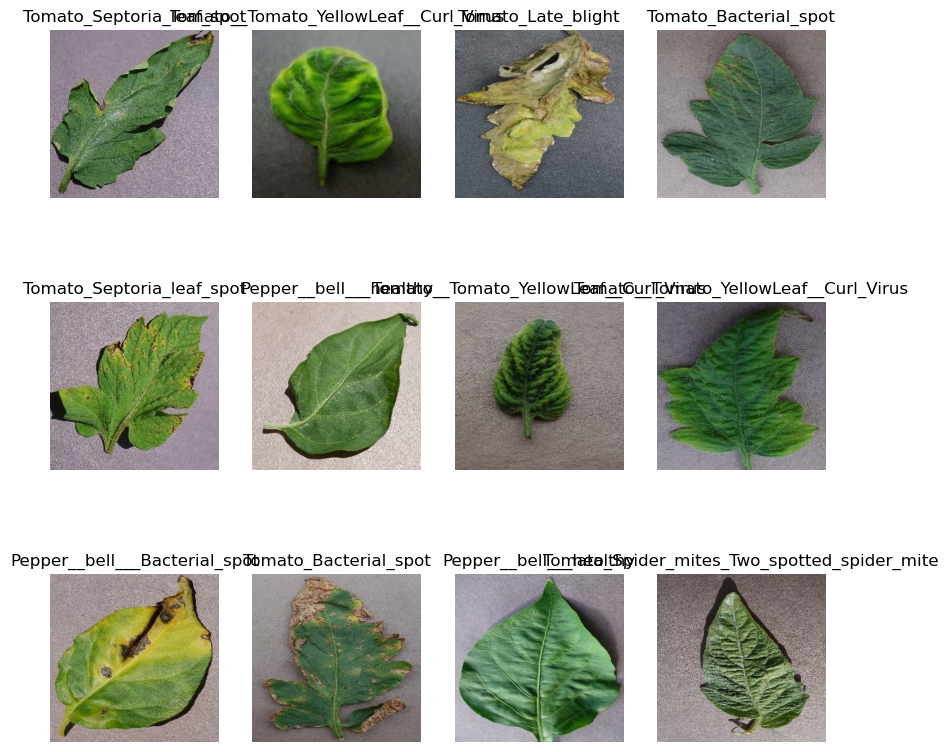

In [15]:
##visualize this image
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [16]:
##80 % ==> training
##20% ==> 10% validation , 10%test

In [17]:
#INORDER TO SPLIT THE DATASET IN SKLEARN WE HAVE TRAINED_TEST_SPLIT
train_size = 0.8
len(dataset)*train_size

516.0

In [18]:
#taking first 54 samples as training datasets
train_ds = dataset.take(54)
len(train_ds)

54

In [19]:
test_ds = dataset.skip(54)
len(test_ds)

591

In [20]:
val_size = 0.1
len(dataset)*val_size

64.5

In [21]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [22]:
##actual test datasets
test_ds = test_ds.skip(6)
len(test_ds)

585

In [23]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [24]:
train_ds , val_ds , test_ds = get_dataset_partitions_tf(dataset)

In [25]:
len(train_ds)

516

In [26]:
len(val_ds)

64

In [27]:
len(test_ds)

65

In [28]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [29]:
IMAGE_SIZE = (224, 224)

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(*IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [30]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])



In [31]:
input_shape = (224, 224, 3)  # Example input shape for images of size 224x224 with 3 color channels (RGB)
n_classes = 20

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# Now you can build your model with the correct input shape
model.build(input_shape=(32,) + input_shape)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 222, 222, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 111, 111, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 109, 109, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 54, 54, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 52, 52, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 26, 26, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 24, 24, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 12, 12, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 10, 10, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 5, 5, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 3, 3, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 1, 1, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 20)               │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 172,564 (674.08 KB)

 Trainable params: 172,564 (674.08 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [34]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.2202 - loss: 2.4113

2024-04-30 12:01:51.687471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:13: Filling up shuffle buffer (this may take a while): 621 of 10000
2024-04-30 12:01:52.437242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-04-30 12:01:53.062368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


516/516 ━━━━━━━━━━━━━━━━━━━━ 293s 553ms/step - accuracy: 0.2205 - loss: 2.4106 - val_accuracy: 0.5239 - val_loss: 1.3952
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 292s 566ms/step - accuracy: 0.6102 - loss: 1.1665 - val_accuracy: 0.7017 - val_loss: 0.8797
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 278s 538ms/step - accuracy: 0.7595 - loss: 0.7122 - val_accuracy: 0.8140 - val_loss: 0.5279
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 277s 537ms/step - accuracy: 0.8269 - loss: 0.5165 - val_accuracy: 0.8320 - val_loss: 0.4855
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 277s 537ms/step - accuracy: 0.8739 - loss: 0.3737 - val_accuracy: 0.8887 - val_loss: 0.3202
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 291s 564ms/step - accuracy: 0.8986 - loss: 0.2983 - val_accuracy: 0.9067 - val_loss: 0.2610
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 314s 607ms/step - accuracy: 0.9168 - loss: 0.2453 - val_accuracy: 0.8755 - val_loss: 0.3671
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 309s 599ms/step - accuracy: 0.9150 - loss: 0.24

In [35]:
scores = model.evaluate(test_ds)

2024-04-30 12:46:13.843360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:13: Filling up shuffle buffer (this may take a while): 515 of 10000
2024-04-30 12:46:17.382239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-04-30 12:46:18.059053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 169ms/step - accuracy: 0.9532 - loss: 0.1462


In [36]:
scores

[0.15159188210964203, 0.9485576748847961]

In [37]:
history

In [38]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 516}

In [39]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
#run prediction on a sample images

first image to predict
actual label: Pepper__bell___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
predicted label: Pepper__bell___healthy


2024-04-30 12:46:58.659531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


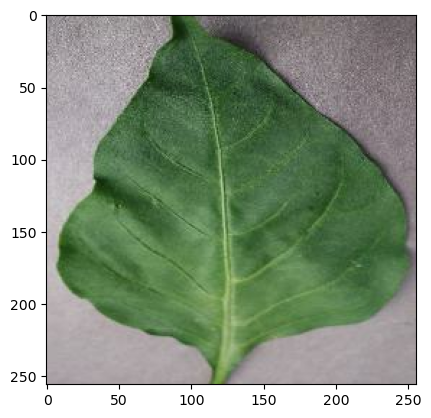

In [42]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [43]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-04-30 12:47:10.108767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


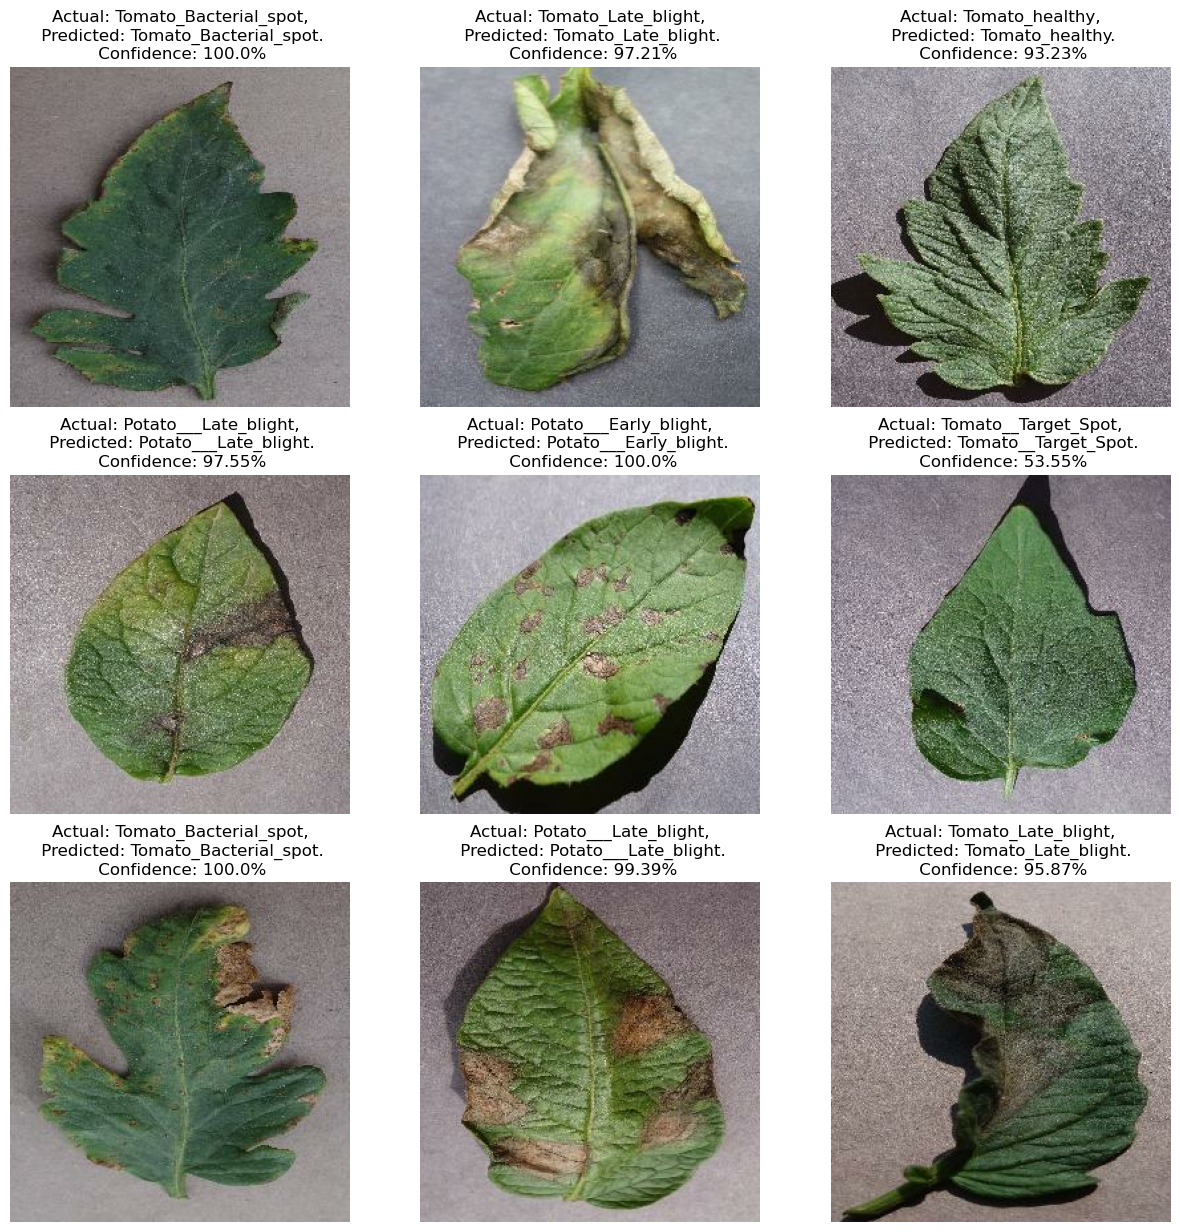

In [44]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [47]:
import os

# Filter out non-integer filenames and convert the remaining ones to integers
model_versions = [int(i) for i in os.listdir("/Users/master/Downloads/PlantVillage") if i.isdigit()]

# Get the maximum version or default to 0 if no versions found
model_version = max(model_versions) + 1 if model_versions else 1

# Save the model with the new version number and correct extension
model.save(f"/Users/master/Downloads/PlantVillage/model_{model_version}.keras")
